In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [369]:
# data libraries
import pandas as pd
import numpy as np
# train model
import torch.optim as optim
import time

In [375]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [386]:
# create dataset
class ClimeDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        # fill Nan with 0
        self.data.fillna(0, inplace=True)
        # take only the values from 'Sensor_id' == ANL11
        self.data = self.data[self.data['Sensor_id'] == 'ANL11']
        # drop 'Sensor_id' column
        self.data.drop(['Sensor_id'], axis=1, inplace=True)
        # change index to dia
        self.data.index = pd.to_datetime(self.data['Dia'])
        # drop 'dia' column
        self.data.drop(['Dia'], axis=1, inplace=True)
        # drop [Unnamed: 0] and [Regristros_id] columns
        self.data.drop(['Unnamed: 0', 'Registros_id'], axis=1, inplace=True)
        # sort by index
        self.data.sort_index(inplace=True)
        # standardize data
        self.data = (self.data - self.data.mean()) / self.data.std()
        # make it a tensor
        self.data = torch.tensor(self.data.values, dtype=torch.float32)
        # make y that is the next day
        self.y = self.data[1:].to(device)
        self.x = self.data[:-1].to(device)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx].unsqueeze(0), self.y[idx].unsqueeze(0)


In [387]:
# Define the model 
class WeatherPred (nn.Module):

    def __init__(self, input, hidden, output, num_layers, num_linear=1):
        super(WeatherPred, self).__init__()
        self.input = input
        self.hidden = hidden
        self.output = output
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input, hidden, num_layers)
        LinearSeq = []
        for i in range(num_linear):
            LinearSeq.append(nn.Linear(hidden, hidden))
            LinearSeq.append(nn.ReLU())
        self.LinearSeq = nn.Sequential(*LinearSeq)
        self.LinearOut = nn.Linear(hidden, output)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.normal_(m.bias)

    def forward(self, x, future=0):
        # Input: (seq_len, batch, input_size)
        outputs = []
        h_t = torch.zeros(self.num_layers, x.size(1), self.hidden).to(device)
        c_t = torch.zeros(self.num_layers, x.size(1), self.hidden).to(device)
        
        for input_t in x.split(1, dim=0):
            output, (h_t, c_t) = self.lstm(input_t, (h_t, c_t))
            output = self.LinearSeq(output)
            output = self.LinearOut(output)
            outputs += [output]

        for i in range(future):
            output, (h_t, c_t) = self.lstm(output, (h_t, c_t))
            output = self.LinearSeq(output)
            output = self.LinearOut(output)
            outputs += [output]

        outputs = torch.cat(outputs, dim=0)
        return outputs

In [388]:
# parametros del entrenamiento
learning_rate = 0.001
num_epochs = 1000
batch_size = 240
clip = .5
future = 100
Prediction_weight = 1.2
dataset = ClimeDataset('DataSQL/dfNL.csv')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [408]:
print (dataset.data.shape[1])

14


In [398]:
input_size = dataset.data.shape[1]
print (input_size)
argument = {
    'input': input_size,
    'hidden': 32,
    'output': input_size,
    'num_layers': 3,
    'num_linear': 2
}
model = WeatherPred(**argument).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [399]:
# plot results
from email import iterators
import matplotlib.pyplot as plt

# plot results
def plot_results(dataloader, future_size):
    iterat = iter(dataloader)
    x, y = next(iterat)
    x = x.to(device)
    y = y.to(device)
    out = model(x[:-future_size], future_size)
    out = out.cpu().detach().numpy()[:,0,7]
    y_real = y.cpu().detach().numpy()[:,0,7]
    plt.plot(y_real, label='Real')
    plt.plot(out, label='Pred')
    plt.axvline(x=x.shape[0]-future_size, color='r', linestyle='--')
    plt.legend()
    plt.show()
    

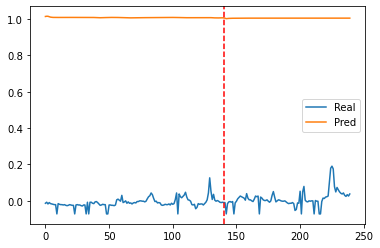

In [400]:
plot_results(dataloader, future)

In [401]:
from tqdm import tqdm

In [402]:
# get a sample
sample = next(iter(dataloader))
# print shape
print(sample[0].shape)

torch.Size([240, 1, 14])


100%|██████████| 151/151 [01:00<00:00,  2.50it/s]


Epoch: 0, Loss: 0.8066


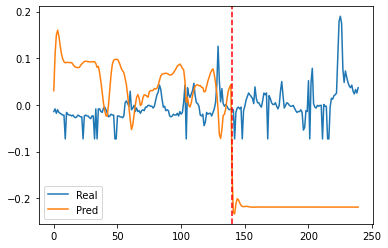

100%|██████████| 151/151 [00:56<00:00,  2.67it/s]


Epoch: 3, Loss: 0.8157


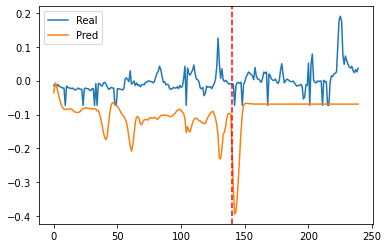

100%|██████████| 151/151 [00:55<00:00,  2.71it/s]


Epoch: 6, Loss: 0.8219


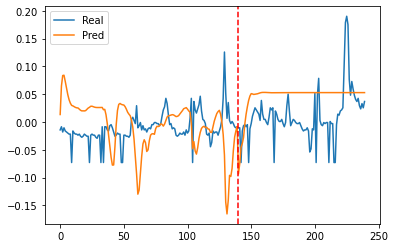

100%|██████████| 151/151 [00:56<00:00,  2.67it/s]


Epoch: 9, Loss: 0.8284


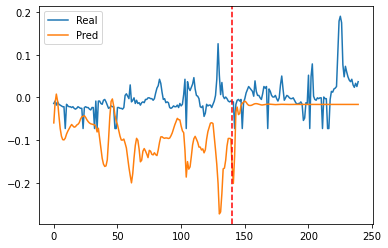

100%|██████████| 151/151 [00:56<00:00,  2.69it/s]

Epoch: 12, Loss: 0.8264


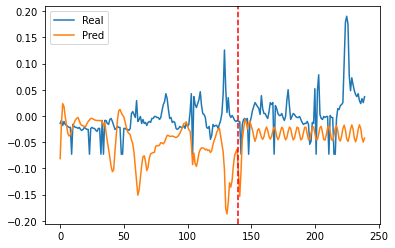

100%|██████████| 151/151 [00:55<00:00,  2.71it/s]


Epoch: 15, Loss: 0.8259


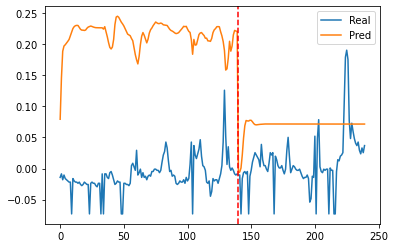

100%|██████████| 151/151 [00:56<00:00,  2.68it/s]


Epoch: 18, Loss: 0.8333


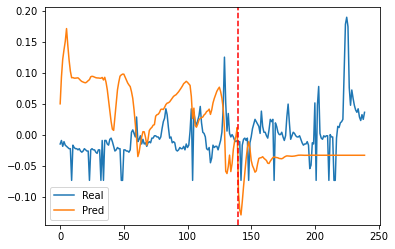

 32%|███▏      | 49/151 [00:18<00:38,  2.63it/s]


KeyboardInterrupt: 

In [410]:

for epoch in range(num_epochs):
    mean_loss = 0.0
    epoch_bar = tqdm(dataloader)
    for i, (x, y) in enumerate(epoch_bar):
        if x.shape[0] != batch_size:
            continue
        out = model(x[:-future], future=future)
        teached_out = y[:-future]
        predicted_out = out[-future:]
        teacher_loss = criterion(teached_out, y[:-future])
        prediction_loss = criterion(predicted_out, y[-future:])
        loss = teacher_loss + Prediction_weight * prediction_loss
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        mean_loss += loss.item()
    mean_loss /= len(dataloader)
    # make checkpoint
    torch.save(model.state_dict(), 'checkpoints.pt')
    if epoch % 3 == 0:
        print (f'Epoch: {epoch}, Loss: {mean_loss:.4f}')
        plot_results(dataloader,future)

In [409]:
# save the model 
torch.save(model.state_dict(), 'model.pt')

100%|██████████| 46/46 [00:17<00:00,  2.69it/s]


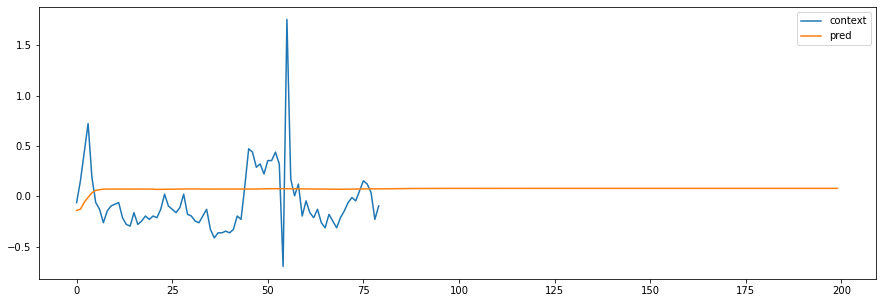

Epoch: 0 - Loss: 1.9488 - Time: 17.1093


100%|██████████| 46/46 [00:18<00:00,  2.52it/s]


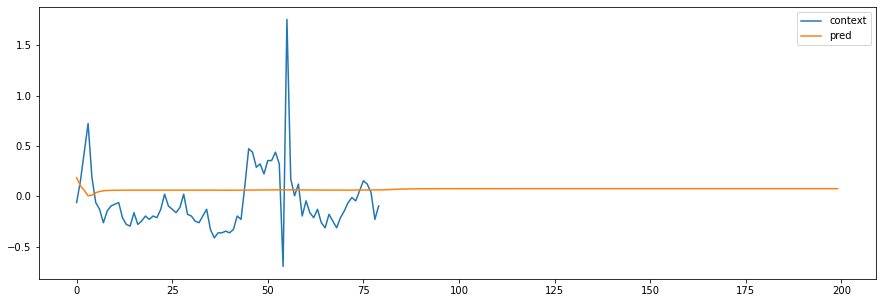

Epoch: 3 - Loss: 1.9270 - Time: 18.2307


100%|██████████| 46/46 [00:13<00:00,  3.38it/s]


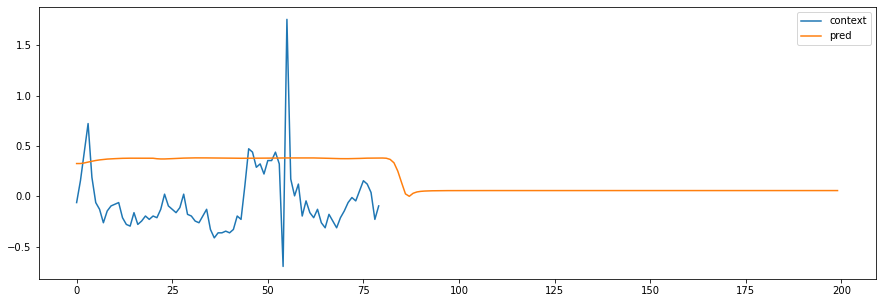

Epoch: 6 - Loss: 1.8817 - Time: 13.5987


100%|██████████| 46/46 [00:08<00:00,  5.26it/s]


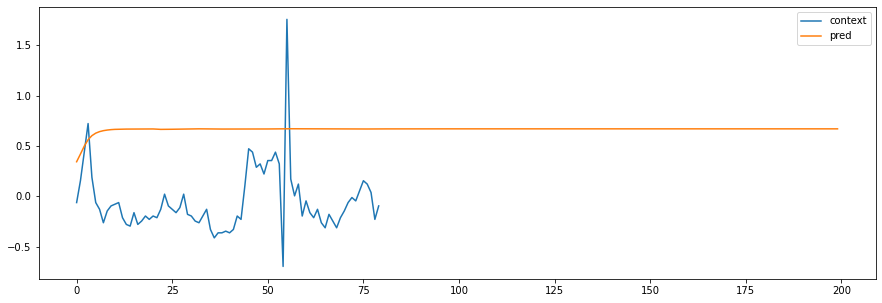

Epoch: 9 - Loss: 1.7381 - Time: 8.7418


100%|██████████| 46/46 [00:08<00:00,  5.67it/s]


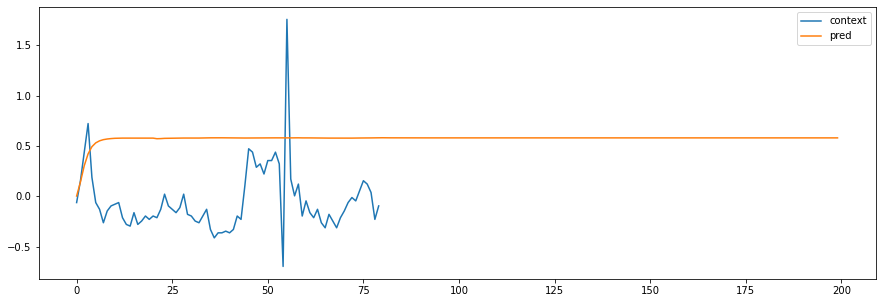

Epoch: 12 - Loss: 1.5801 - Time: 8.1225


100%|██████████| 46/46 [00:08<00:00,  5.70it/s]


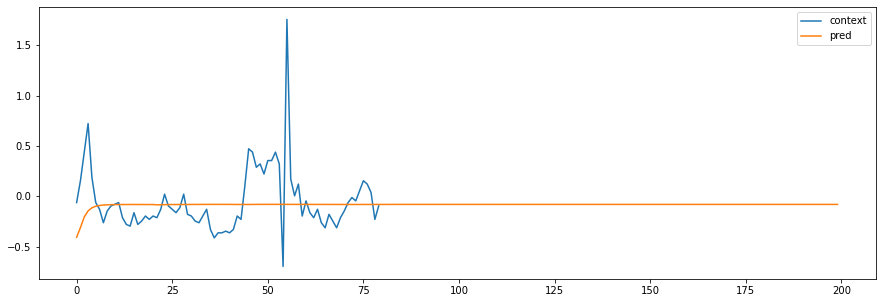

Epoch: 15 - Loss: 1.4938 - Time: 8.0807


100%|██████████| 46/46 [00:08<00:00,  5.20it/s]


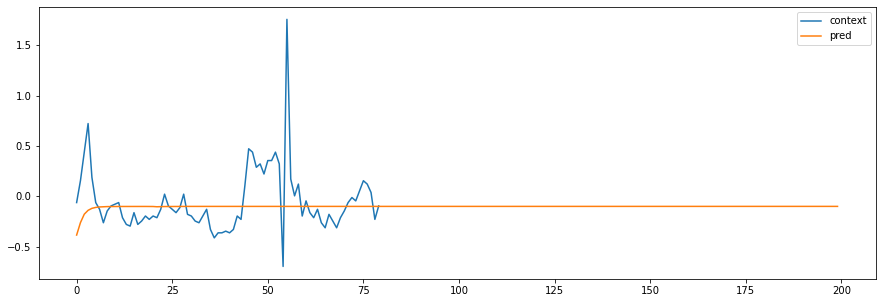

Epoch: 18 - Loss: 1.4672 - Time: 8.8425


100%|██████████| 46/46 [00:09<00:00,  4.64it/s]


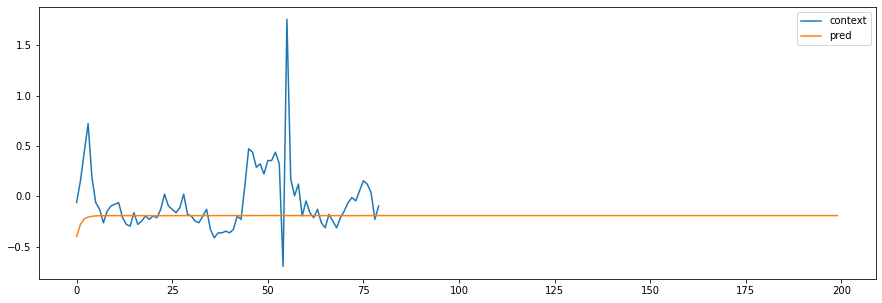

Epoch: 21 - Loss: 1.4569 - Time: 9.9133


 80%|████████  | 37/46 [00:09<00:02,  3.90it/s]


KeyboardInterrupt: 

In [357]:
# train model
for epoch in range(100):
    train_model(Model, ClimLoader, criterion, optimizer, epoch)

In [246]:
# test model
def test_model(model, context, future_size):
    model.eval()
    with torch.no_grad():
        pred = model(context, future_size)
    return pred

In [247]:
# test model
for batch in ClimLoader:
    # change [batch_size, seq_len, input_size] to [seq_len, batch_size, input_size]
    batch = batch.permute(1, 0, 2)
    contex_size = int(batch.shape[0] * future)
    context = batch[-contex_size:, :, :]
    future_size = batch.shape[0] - contex_size
    pred = test_model(Model, context, future_size)
    break

AttributeError: 'list' object has no attribute 'permute'

In [248]:
# plot results
def plot_results(pred, context, future_size):
    pred = pred.detach().numpy()
    context = context.detach().numpy()
    plt.figure(figsize=(15, 5))
    xcontext = np.arange(0, pred.shape[0]-future_size)
    xpred = np.arange(pred.shape[0] - future_size, pred.shape[0])
    plt.plot(xcontext, context[:, 0, 0], label='context')
    plt.plot(xpred, pred[-future_size:, 0, 0], label='pred')
    plt.legend()
    plt.show()

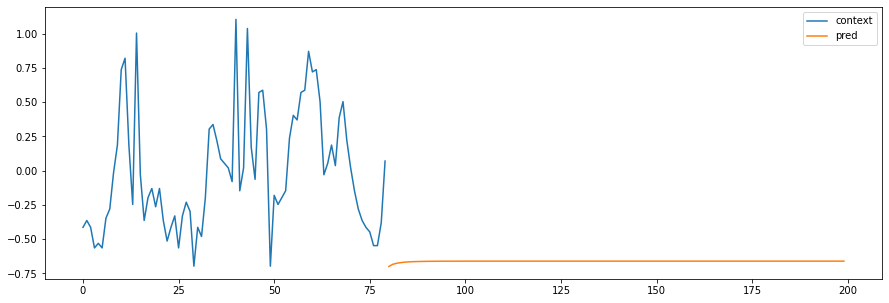

In [249]:
# plot results
plot_results(pred, context, future_size)

In [250]:
# plot results
out = Model(batch, 10)
# take the last 10 output
out = out[-10:, :, :]
plt.figure(figsize=(15, 5))
plt.plot(out[:, 0, 0].detach().numpy(), label='pred')
plt.legend()
plt.show()

AttributeError: 'list' object has no attribute 'size'